In [1]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np

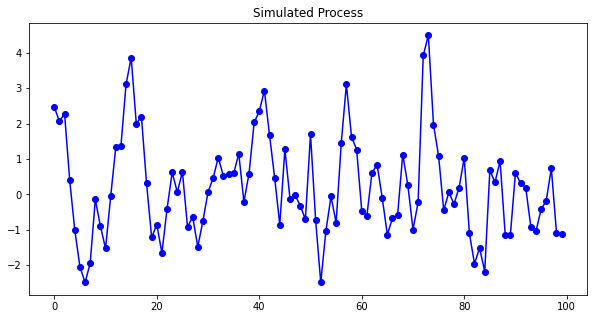

In [2]:
# Generate the data
import numpy as np
ar = np.array([1, -0.8, 0.2])
ma = np.array([1])
my_simulation = ArmaProcess(ar, ma).generate_sample(nsample=100)

plt.figure(figsize=[10, 5]); # Set dimensions for figure
plt.plot(my_simulation, linestyle='-', marker='o', color='b')
plt.title("Simulated Process")
plt.show()

C:\Users\55839\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


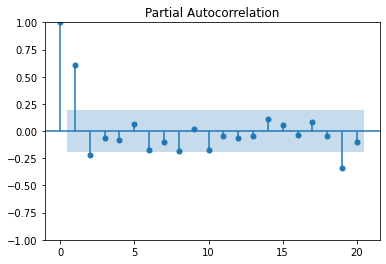

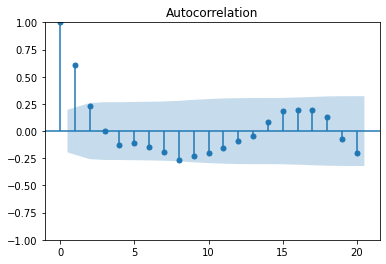

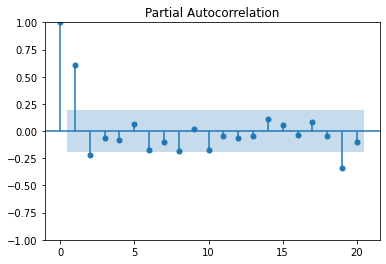

In [3]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
plot_acf(my_simulation)  # ACF
plot_pacf(my_simulation) # PACF

In [4]:
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

mod = sm.tsa.arima.ARIMA(my_simulation, order=(2, 0, 0))
mod_fit = mod.fit()
print(mod_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -150.962
Date:                Mon, 13 Dec 2021   AIC                            309.924
Time:                        09:11:09   BIC                            320.345
Sample:                             0   HQIC                           314.141
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2293      0.248      0.926      0.354      -0.256       0.714
ar.L1          0.7513      0.097      7.741      0.000       0.561       0.942
ar.L2         -0.2161      0.102     -2.123      0.0

There are 1510 observations in the training data
There are 251 observations in the test data


<AxesSubplot:xlabel='Date'>

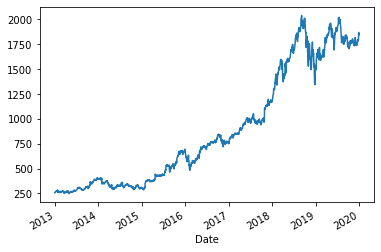

In [5]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2019-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)
print("There are "+ str(all_data[:'2018'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2019':].shape[0]) + " observations in the test data")
all_data['Adj Close'].plot()
# There are 1,510 and 251 observations in the training and test data respectively.

In [6]:
!pip install YahooFinancials

C:\Users\55839\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


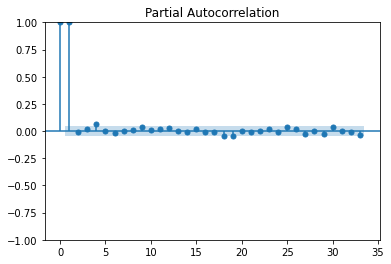

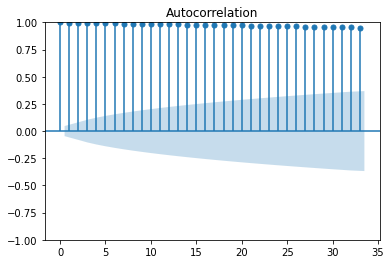

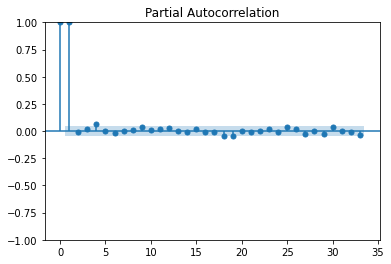

In [7]:
plot_acf(all_data['Close'])  # ACF
plot_pacf(all_data['Close']) # PACF

In [8]:
# create training and test set
ts_train = all_data[:'2018'].iloc[:,0:1].values
ts_test  = all_data['2019':].iloc[:,0:1].values
ts_train_len = len(ts_train)
ts_test_len = len(ts_test)

In [9]:
ts_train_len

1510

In [38]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
ts_train_scaled = sc.fit_transform(ts_train)

In [39]:
# create training data of s samples and t time steps
X_train = []
y_train = []
y_train_stacked = []
time_steps = 5
for_periods = 2
for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [40]:
np.shape(y_train)

(1504, 2)

In [41]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [42]:
np.shape(X_train)

(1504, 5, 1)

In [43]:
X_train

array([[[0.005069  ],
        [0.00572217],
        [0.0060962 ],
        [0.0112936 ],
        [0.01013242]],

       [[0.00572217],
        [0.0060962 ],
        [0.0112936 ],
        [0.01013242],
        [0.01011567]],

       [[0.0060962 ],
        [0.0112936 ],
        [0.01013242],
        [0.01011567],
        [0.00955183]],

       ...,

       [[0.72755236],
        [0.6960665 ],
        [0.67694609],
        [0.63039837],
        [0.61170225]],

       [[0.6960665 ],
        [0.67694609],
        [0.63039837],
        [0.61170225],
        [0.68256777]],

       [[0.67694609],
        [0.63039837],
        [0.61170225],
        [0.68256777],
        [0.67739829]]])

In [44]:
# Preparing to create X_test
inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]),axis=0).values
inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [45]:
X_train.shape[0],X_train.shape[1]

(1504, 5)

In [46]:
# Convert the 3-D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

,0,1,2,3,4,0,1
0,0.005069,0.005722,0.006096,0.011294,0.010132,0.010116,0.009552
1,0.005722,0.006096,0.011294,0.010132,0.010116,0.009552,0.011003
2,0.006096,0.011294,0.010132,0.010116,0.009552,0.011003,0.013677
3,0.011294,0.010132,0.010116,0.009552,0.011003,0.013677,0.013214
4,0.010132,0.010116,0.009552,0.011003,0.013677,0.013214,0.011556
...,...,...,...,...,...,...,...
1499,0.750123,0.710486,0.727552,0.696066,0.676946,0.630398,0.611702
1500,0.710486,0.727552,0.696066,0.676946,0.630398,0.611702,0.682568
1501,0.727552,0.696066,0.676946,0.630398,0.611702,0.682568,0.677398
1502,0.696066,0.676946,0.630398,0.611702,0.682568,0.677398,0.686543


In [47]:
# Convert the 3-D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

,0,1,2,3,4
0,0.611702,0.682568,0.677398,0.686543,0.699913
1,0.682568,0.677398,0.686543,0.699913,0.720658
2,0.677398,0.686543,0.699913,0.720658,0.698969
3,0.686543,0.699913,0.720658,0.698969,0.740900
4,0.699913,0.720658,0.698969,0.740900,0.771113
...,...,...,...,...,...
244,0.844145,0.844486,0.849102,0.861077,0.857376
245,0.844486,0.849102,0.861077,0.857376,0.861981
246,0.849102,0.861077,0.857376,0.861981,0.858755
247,0.861077,0.857376,0.861981,0.858755,0.862383


In [48]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1504 samples in the training data
There are 249 samples in the test data


In [20]:
# create a model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [49]:
my_rnn_model = Sequential()
my_rnn_model.add(SimpleRNN(32, return_sequences=True))
my_rnn_model.add(SimpleRNN(32))
my_rnn_model.add(Dense(2)) # The time step of the outpu

In [50]:
my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

In [51]:
# fit the RNN model
my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

In [53]:
# Finalizing predictions
rnn_predictions = my_rnn_model.predict(X_test)
from sklearn.preprocessing import MinMaxScaler
rnn_predictions = sc.inverse_transform(rnn_predictions)

In [54]:
actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(rnn_predictions)]
actual_pred['prediction'] = rnn_predictions[:,0]

In [55]:
from keras.metrics import MeanSquaredError
m = MeanSquaredError()
m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [56]:
m.result().numpy()

2136.6301

<AxesSubplot:xlabel='Date'>

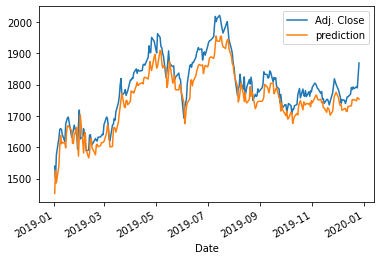

In [57]:
actual_pred.plot()

In [61]:
# create a model
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from tensorflow.keras.optimizers import SGD

In [62]:
# The LSTM architecture
my_LSTM_model = Sequential()
my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
my_LSTM_model.add(LSTM(units=50, activation='tanh'))
my_LSTM_model.add(Dense(units=2))

In [65]:
# Compiling
my_LSTM_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, 
                      nesterov=False),loss='mean_squared_error')

In [66]:
# Fitting to the training set
my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

In [68]:
LSTM_prediction = my_LSTM_model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction)

In [69]:
actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(LSTM_prediction)]
actual_pred['prediction'] = LSTM_prediction[:,0]

In [70]:
from keras.metrics import MeanSquaredError
m = MeanSquaredError()
m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [71]:
m.result().numpy()

2185.158

<AxesSubplot:xlabel='Date'>

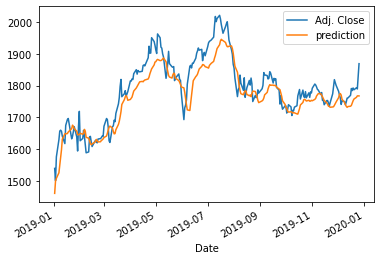

In [72]:
actual_pred.plot()

In [74]:
# create a model
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout

In [75]:
# The LSTM architecture
my_LSTM_model = Sequential()
my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
my_LSTM_model.add(LSTM(units=50, activation='tanh'))
my_LSTM_model.add(Dropout(0.2))
my_LSTM_model.add(Dense(units=2))

In [77]:
#Compiling
my_LSTM_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, 
                      nesterov=False),loss='mean_squared_error')

In [78]:
# Fitting to the training set
my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

In [79]:
LSTM_prediction = my_LSTM_model.predict(X_test)
LSTM_prediction = sc.inverse_transform(LSTM_prediction)

In [80]:
actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(LSTM_prediction)]
actual_pred['prediction'] = LSTM_prediction[:,0]

In [81]:
from keras.metrics import MeanSquaredError
m = MeanSquaredError()
m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [82]:
m.result().numpy()

2820.2249

<AxesSubplot:xlabel='Date'>

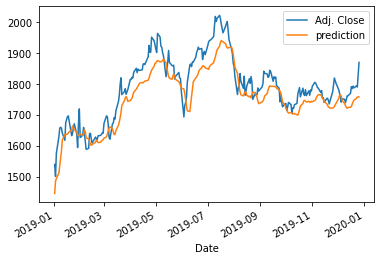

In [83]:
actual_pred.plot()

# GRU

In [84]:
# The GRU architecture
my_GRU_model = Sequential()
# First GRU layer with Dropout regularisation
my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
#my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
my_GRU_model.add(GRU(units=50, activation='tanh'))
my_GRU_model.add(Dense(units=2))

In [86]:
# Compiling the RNN
my_GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, 
                 momentum=0.9, nesterov=False),loss='mean_squared_error')

In [87]:
#Fitting to the training set
my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

In [88]:
GRU_prediction = my_GRU_model.predict(X_test)
GRU_prediction = sc.inverse_transform(GRU_prediction)

In [89]:
actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(GRU_prediction)]
actual_pred['prediction'] = GRU_prediction[:,0]

In [90]:
m = MeanSquaredError()
m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [91]:
m.result().numpy()

1327.3473

<AxesSubplot:xlabel='Date'>

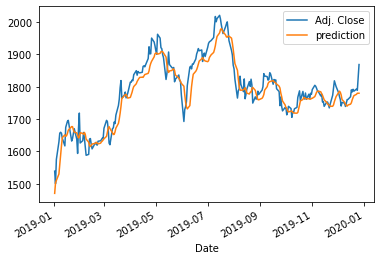

In [92]:
actual_pred.plot()

GRU com Dropout

In [93]:
# The GRU architecture
my_GRU_model = Sequential()
# First GRU layer with Dropout regularisation
my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Second GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))

In [94]:
# Third GRU layer
my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
my_GRU_model.add(Dropout(0.2))
# Fourth GRU layer
my_GRU_model.add(GRU(units=50, activation='tanh'))
my_GRU_model.add(Dropout(0.2))

In [95]:
# The output layer
my_GRU_model.add(Dense(units=2))

In [97]:
# Compiling the RNN
my_GRU_model.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, 
                     nesterov=False),loss='mean_squared_error')

In [98]:
# Fitting to the training set
my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

In [99]:
GRU_predictions = my_GRU_model.predict(X_test)
GRU_predictions = sc.inverse_transform(GRU_predictions)

In [105]:
actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(GRU_predictions)]
actual_pred['prediction'] = GRU_predictions[:,0]

In [106]:
m = MeanSquaredError()
m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [107]:
m.result().numpy()

3909.7131

<AxesSubplot:xlabel='Date'>

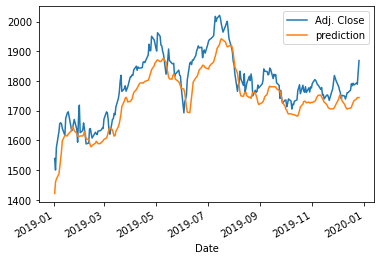

In [108]:
actual_pred.plot()